In [5]:
import os
import cv2
import numpy as np
from random import shuffle
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt
import random
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import RMSprop, Adam
from tensorflow.keras import layers, models
from keras.models import save_model
from keras.layers import Dense, Dropout, Flatten, MaxPool2D, Conv2D
from tensorflow.keras.utils import to_categorical

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download -d gti-upm/leapgestrecog

leapgestrecog.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
import zipfile

zip_ref= zipfile.ZipFile('/content/leapgestrecog.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [9]:
path= '/content/leapGestRecog'
hand_gestures = ["01_palm", "02_l", "03_fist", "04_fist_moved", "05_thumb", "06_index", "07_ok", "08_palm_moved", "09_c", "10_down"]
final_data = [] # An empty list to hold the dictionaries for each gesture.
image_size = (150, 150)

for file in range(10): # Looping through the 10 files containing the gestures.
    file_data = os.path.join(path, f"{file:02d}")
    for gesture in hand_gestures: # Looping through the gestures files.
        gestures_img = os.path.join(file_data, gesture)
        if os.path.exists(gestures_img):
            for filename in os.listdir(gestures_img): # Looping through the images in each gestures file.
                if filename.endswith((".png", ".jpg")):
                    image_path = os.path.join(gestures_img, filename)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    if image is not None: # Checking if it's a valid image
                        resized_image = cv2.resize(image, image_size)
                        final_data.append({"gesture": gesture, "image": resized_image})


In [10]:
total_count = len(final_data)
print(f"total data count: {total_count}")

total data count: 20000


In [11]:
images = np.array([item['image'] for item in final_data])
labels = np.array([item['gesture'] for item in final_data])

images = np.array(images, dtype = 'float32')
labels = np.array(labels)
labels = labels.reshape(total_count, 1)

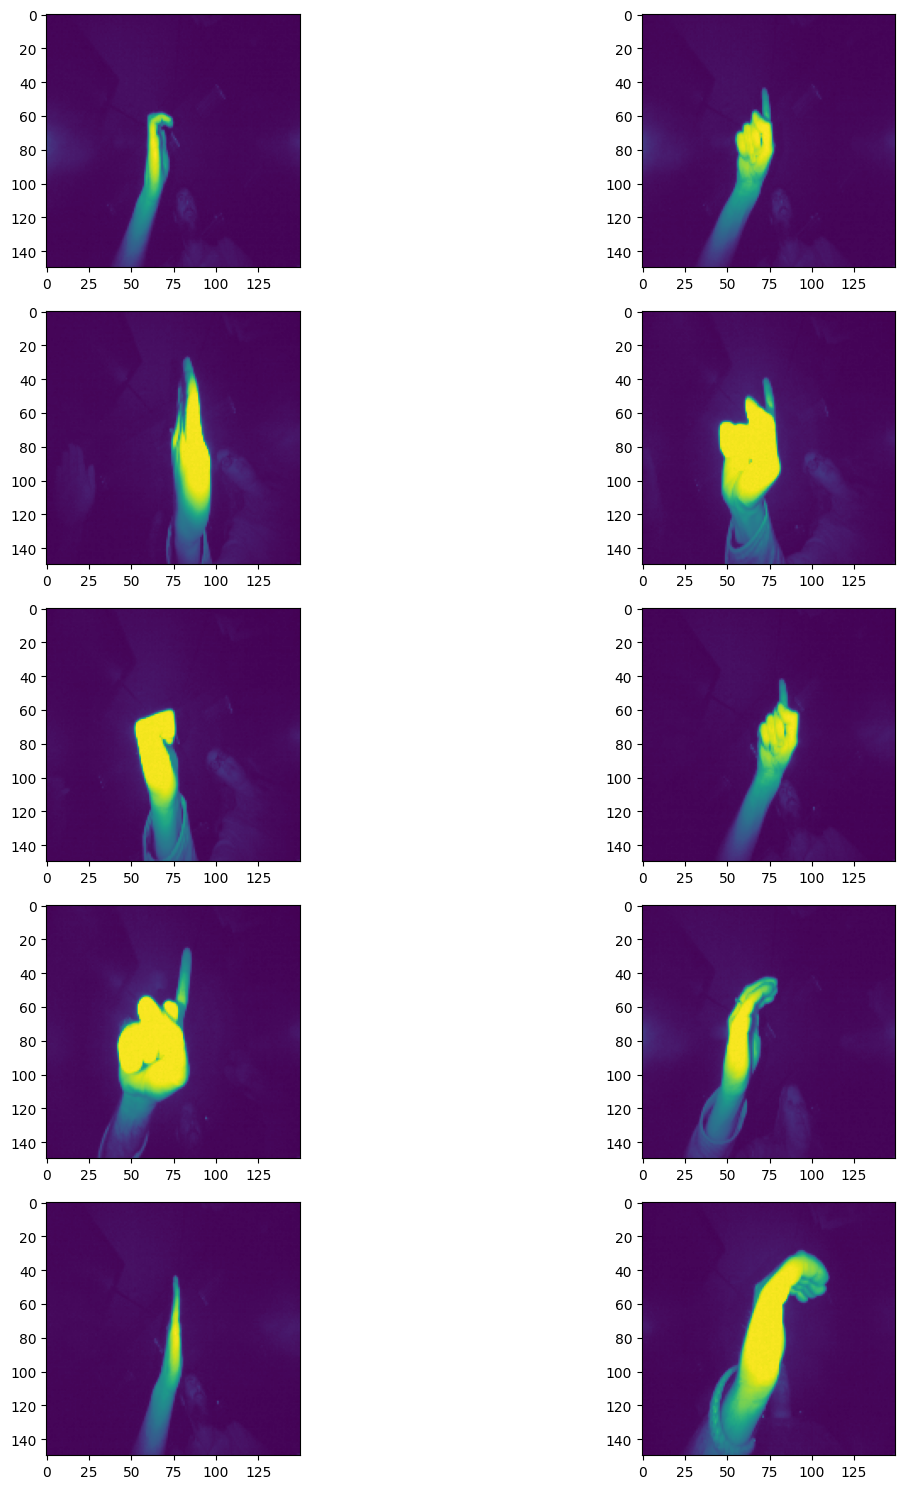

In [12]:
fig,ax = plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l = random.randint(0,len(labels))
        ax[i,j].imshow(images[l])
plt.tight_layout()

In [13]:
# Conversion of labels to numbers

label_encoder= LabelEncoder()
labels= label_encoder.fit_transform(labels)
labels= to_categorical(labels)

# Splitting train and test data

X_train, X_test, y_train, y_test= train_test_split(images, labels, test_size= 0.2, random_state= 42)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
X_train.shape

(16000, 150, 150)

In [15]:
y_train.shape

(16000, 10)

In [16]:
# CNN

model= models.Sequential()

# 1st layer
model.add(Conv2D(filters= 15, kernel_size= (5,5), padding= 'Same',
                 activation= 'relu', input_shape= (150, 150, 1)))
model.add(MaxPool2D(pool_size= (2,2)))
model.add(Dropout(0.25))

# 2nd layer
model.add(Conv2D(filters= 15, kernel_size= (5,5), padding= 'Same',
                 activation= 'relu'))
model.add(MaxPool2D(pool_size= (2,2), strides= (2,2)))
model.add(Dropout(0.25))

# Flatten
model.add(Flatten())

model.add(Dense(512, activation= 'relu'))
model.add(Dense(len(hand_gestures), activation= 'softmax'))

# Optimizer
optimizer= Adam(learning_rate= 0.001, beta_1= 0.9, beta_2= 0.999)

# Compile
model.compile(optimizer= optimizer, loss= 'categorical_crossentropy', metrics= ['accuracy'])

# Early stopping
early_stopping= EarlyStopping(monitor= 'val_loss', patience= 1, restore_best_weights= True)

# Training
history = model.fit(X_train, y_train, epochs = 3, batch_size = 250, validation_data = (X_test, y_test), callbacks = [early_stopping])

test_loss, test_acc= model.evaluate(X_test, y_test)
print("Accuracy: ", test_acc)

Epoch 1/3
64/64 [==============================] - 15s 119ms/step - loss: 15.7126 - accuracy: 0.2685 - val_loss: 1.1566 - val_accuracy: 0.6773
Epoch 2/3
64/64 [==============================] - 7s 103ms/step - loss: 0.5378 - accuracy: 0.8353 - val_loss: 0.1108 - val_accuracy: 0.9753
Epoch 3/3
125/125 [==============================] - 1s 5ms/step - loss: 0.0325 - accuracy: 0.9933
Accuracy:  0.9932500123977661


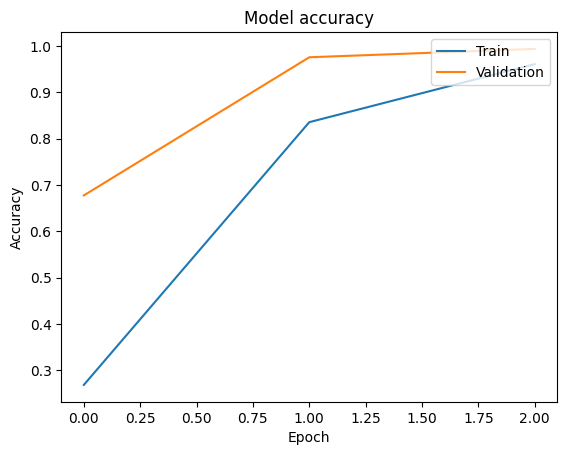

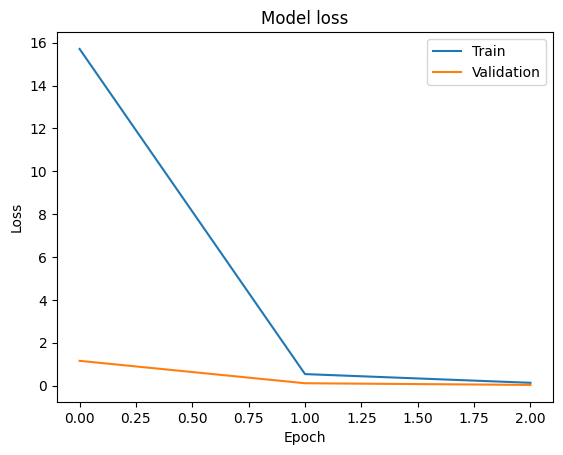

In [18]:
# Plotting the accuracy
def plot(history):
    # The training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper right')
    plt.show()

    # The training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper right')
    plt.show()

# Calling the function
plot(history)

In [ ]:
from tensorflow.keras.models import load_model

model.save('model_gesture.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
